In [1]:
"""Aggregate classroom LLM simulation payloads and recreate key analyses."""
import json
import warnings
from pathlib import Path
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = DATA_DIR / "sim_runs"
AGG_DIR = DATA_DIR / "aggregated"
FIG_DIR = BASE_DIR / "figures" / "aggregation"
TABLE_DIR = BASE_DIR / "outputs" / "aggregation"

for path in (AGG_DIR, FIG_DIR, TABLE_DIR):
    path.mkdir(parents=True, exist_ok=True)

GOOGLE_FORM_URL = "https://docs.google.com/spreadsheets/d/1Itk10eejal9tbcMeHAVKYLLU4bQYQ033LT1DWIDmLFw/export?format=csv"
CACHED_FORM_CSV = AGG_DIR / "google_form_submissions.csv"
HUMAN_LABELS_PATH = DATA_DIR / "ICLR2025" / "ICLR2025_human_reviews_with_decision.csv"

warnings.filterwarnings("ignore", category=ConvergenceWarning)
print(f"Working directory: {BASE_DIR}")

Working directory: /Users/tianyudu/Development/OB639-LLM-ABM-Simulation


In [2]:
import re
from datetime import datetime

ACCEPT_TOKENS = ["accept", "spotlight", "oral", "poster", "conditional"]
REJECT_TOKENS = ["reject", "decline", "no award"]
PAYLOAD_COLUMN_HINTS = [
    "payload",
    "payload_json",
    "payload_blob",
    "json_payload",
    "submit_your_contribution_here",
    "submit_your_payload_here",
    "simulation_payload",
]


def snake_case(text: str) -> str:
    text = text.strip().lower()
    text = re.sub(r"[^a-z0-9]+", "_", text)
    text = re.sub(r"_{2,}", "_", text).strip("_")
    return text or "column"


def make_unique_columns(columns: List[str]) -> List[str]:
    seen: Dict[str, int] = {}
    unique: List[str] = []
    for col in columns:
        count = seen.get(col, 0)
        new_col = col if count == 0 else f"{col}_{count}"
        unique.append(new_col)
        seen[col] = count + 1
    return unique


def try_parse_json(value: Any) -> Optional[Dict[str, Any]]:
    if isinstance(value, dict):
        return value
    if isinstance(value, str) and value.strip():
        try:
            return json.loads(value)
        except json.JSONDecodeError:
            return None
    return None


def normalize_decision(text: Optional[str]) -> Optional[str]:
    if not isinstance(text, str):
        return None
    lowered = text.strip().lower()
    for token in ACCEPT_TOKENS:
        if token in lowered:
            return "accept"
    for token in REJECT_TOKENS:
        if token in lowered:
            return "reject"
    return lowered or None


def decision_to_binary(label: Optional[str]) -> Optional[int]:
    if label == "accept":
        return 1
    if label == "reject":
        return 0
    return None


def _first_valid_value(value: Any) -> Optional[Any]:
    if isinstance(value, pd.Series):
        for item in value.tolist():
            if pd.notna(item):
                return item
        return None
    if isinstance(value, (list, tuple, set)):
        for item in value:
            if pd.notna(item):
                return item
        return None
    return value if pd.notna(value) else None


def infer_student_id(row: pd.Series) -> str:
    candidate_fields = [
        "student_id",
        "name",
        "full_name",
        "preferred_name",
        "team_name",
        "netid",
        "email",
        "email_address",
        "uw_email",
    ]
    for field in candidate_fields:
        if field in row:
            candidate = _first_valid_value(row[field])
            if candidate is not None and str(candidate).strip():
                return str(candidate).strip()
    submission_id = row.get("submission_id")
    if pd.isna(submission_id):
        submission_id = 0
    return f"submission_{int(submission_id):03d}"


def parse_timestamp(series: pd.Series) -> pd.Series:
    if series.dtype == "datetime64[ns]":
        return series
    return pd.to_datetime(series, errors="coerce")


def find_payload_series(df: pd.DataFrame) -> pd.Series:
    if df.empty:
        return pd.Series(dtype=object)

    candidates: List[str] = []
    for col in df.columns:
        col_lower = col.lower()
        for hint in PAYLOAD_COLUMN_HINTS:
            if col_lower == hint or col_lower.startswith(f"{hint}_"):
                candidates.append(col)
                break

    for col in candidates:
        series = df[col]
        if isinstance(series, pd.DataFrame):
            series = series.iloc[:, 0]
        if series.notna().any():
            return series

    if candidates:
        series = df[candidates[0]]
        return series.iloc[:, 0] if isinstance(series, pd.DataFrame) else series

    for col in df.columns:
        series = df[col]
        if isinstance(series, pd.DataFrame):
            continue
        try:
            sample = series.astype(str).str.strip()
        except Exception:
            continue
        mask = sample.str.startswith("{") & sample.str.endswith("}")
        if mask.mean() > 0.5:
            return series

    return pd.Series([None] * len(df), index=df.index, dtype=object)


In [3]:
def load_google_form_submissions(csv_url: str, cache_path: Path) -> pd.DataFrame:
    """Download the classroom sheet (with cache fallback) and return raw rows."""
    if not csv_url:
        return pd.DataFrame()

    try:
        print("Fetching Google Sheet submissions…")
        remote_df = pd.read_csv(csv_url)
        if cache_path:
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            remote_df.to_csv(cache_path, index=False)
        remote_df["source"] = "google_form"
        remote_df["source_path"] = csv_url
        return remote_df
    except Exception as exc:  # noqa: broad-except
        print(f"⚠️ Unable to download Google Sheet ({exc}).")

    if cache_path and cache_path.exists():
        try:
            cached_df = pd.read_csv(cache_path)
            cached_df["source"] = "google_form_cache"
            cached_df["source_path"] = str(cache_path)
            print(f"Loaded cached submissions from {cache_path}.")
            return cached_df
        except Exception as exc:  # noqa: broad-except
            print(f"⚠️ Unable to read cached CSV ({exc}).")

    print("⚠️ No Google Sheet data available.")
    return pd.DataFrame()


def load_json_directory(result_dir: Path) -> pd.DataFrame:
    """Optional: load standalone JSON payloads dropped in a directory."""
    if not result_dir.exists():
        return pd.DataFrame()

    rows: List[Dict[str, Any]] = []
    for file_path in result_dir.rglob("*.json"):
        try:
            payload = json.loads(file_path.read_text())
            rows.append(
                {
                    "payload": payload,
                    "source": "json_file",
                    "source_path": str(file_path),
                    "timestamp": datetime.fromtimestamp(file_path.stat().st_mtime),
                }
            )
        except Exception as exc:  # noqa: broad-except
            print(f"⚠️ Could not parse {file_path}: {exc}")
    return pd.DataFrame(rows)


def prepare_submissions() -> pd.DataFrame:
    """Combine sheet + directory payloads and normalize columns."""
    frames: List[pd.DataFrame] = []

    sheet_df = load_google_form_submissions(GOOGLE_FORM_URL, CACHED_FORM_CSV)
    if not sheet_df.empty:
        frames.append(sheet_df)

    json_df = load_json_directory(RESULTS_DIR)
    if not json_df.empty:
        frames.append(json_df)

    if not frames:
        print("⚠️ No submissions found. Add JSON payloads or update the sheet URL.")
        return pd.DataFrame()

    combined = pd.concat(frames, ignore_index=True, sort=False)
    combined = combined.rename(columns=lambda c: snake_case(str(c)))
    combined.columns = make_unique_columns(list(combined.columns))

    if "timestamp" in combined.columns:
        combined["timestamp"] = parse_timestamp(combined["timestamp"])

    payload_series = find_payload_series(combined)
    if payload_series.isnull().all():
        print("⚠️ Unable to locate a payload column with JSON content; verify submissions include the exported blob from LLM_review_simulation.ipynb.")
    combined["payload_raw"] = payload_series
    combined["payload"] = combined["payload_raw"].apply(try_parse_json)
    combined["payload_valid"] = combined["payload"].apply(lambda val: isinstance(val, dict))

    parsed = combined[combined["payload_valid"]].copy()
    parsed.reset_index(drop=True, inplace=True)
    parsed["submission_id"] = np.arange(len(parsed)) + 1
    if "source" not in parsed.columns:
        parsed["source"] = "unknown"

    parsed["student_id"] = parsed.apply(infer_student_id, axis=1)
    parsed["paper_id"] = parsed["payload"].apply(lambda pack: (pack.get("paper") or {}).get("paper_id"))
    parsed["paper_domain"] = parsed["payload"].apply(lambda pack: (pack.get("paper") or {}).get("paper_domain"))
    parsed["generated_at"] = parsed["payload"].apply(lambda pack: pack.get("generated_at"))

    print(f"Loaded {len(parsed)} valid submissions (dropped {len(combined) - len(parsed)} invalid rows).")
    return parsed


submissions_df = prepare_submissions()
submissions_df.head()

Fetching Google Sheet submissions…
Loaded 4 valid submissions (dropped 0 invalid rows).


,timestamp,submit_your_contribution_here,source,source_path,payload_raw,payload,payload_valid,submission_id,student_id,paper_id,paper_domain,generated_at
0,2025-12-01 01:02:52,"{\n ""generated_at"": ""2025-12-01T09:02:05.5256...",google_form,https://docs.google.com/spreadsheets/d/1Itk10e...,"{\n ""generated_at"": ""2025-12-01T09:02:05.5256...",{'generated_at': '2025-12-01T09:02:05.525628Z'...,True,1,submission_001,unknown,unknown,2025-12-01T09:02:05.525628Z
1,2025-12-01 01:08:17,"{\n ""generated_at"": ""2025-12-01T09:07:26.6073...",google_form,https://docs.google.com/spreadsheets/d/1Itk10e...,"{\n ""generated_at"": ""2025-12-01T09:07:26.6073...",{'generated_at': '2025-12-01T09:07:26.607323Z'...,True,2,submission_002,unknown,unknown,2025-12-01T09:07:26.607323Z
2,2025-12-01 01:29:14,"{\n ""generated_at"": ""2025-12-01T09:28:38.3316...",google_form,https://docs.google.com/spreadsheets/d/1Itk10e...,"{\n ""generated_at"": ""2025-12-01T09:28:38.3316...",{'generated_at': '2025-12-01T09:28:38.331695Z'...,True,3,submission_003,unknown,unknown,2025-12-01T09:28:38.331695Z
3,2025-12-01 01:49:27,"{\n ""generated_at"": ""2025-12-01T09:43:45.4641...",google_form,https://docs.google.com/spreadsheets/d/1Itk10e...,"{\n ""generated_at"": ""2025-12-01T09:43:45.4641...",{'generated_at': '2025-12-01T09:43:45.464143Z'...,True,4,submission_004,unknown,unknown,2025-12-01T09:43:45.464143Z


In [4]:
def build_run_metadata(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    records: List[Dict[str, Any]] = []
    for row in df.itertuples():
        payload = getattr(row, "payload", {}) or {}
        panel_state = payload.get("ai_panel_state") or []
        domains = [member.get("domain") for member in panel_state if isinstance(member, dict)]
        domain_counts = pd.Series(domains).value_counts() if domains else pd.Series(dtype=int)

        human_ai_cfg = ((payload.get("human_ai_mixture") or {}).get("config") or {})
        outsider_cfg = payload.get("outsider_mixture") or {}

        records.append(
            {
                "submission_id": row.submission_id,
                "student_id": row.student_id,
                "source": getattr(row, "source", "unknown"),
                "timestamp": getattr(row, "timestamp", pd.NaT),
                "paper_id": getattr(row, "paper_id", None),
                "paper_domain": getattr(row, "paper_domain", None),
                "generated_at": payload.get("generated_at"),
                "ai_panel_size": len(panel_state),
                "ai_panel_same_domain": int(domain_counts.get("same", 0)),
                "ai_panel_random_different": int(domain_counts.get("random_different", 0)),
                "ai_panel_other": int(domain_counts.sum() - domain_counts.get("same", 0) - domain_counts.get("random_different", 0)) if not domain_counts.empty else 0,
                "has_human_ai_mixture": bool(payload.get("human_ai_mixture")),
                "has_outsider_mixture": bool(payload.get("outsider_mixture")),
                "human_ai_num_ai_reviews_tested": human_ai_cfg.get("num_ai_reviews_tested"),
                "human_ai_num_shuffle_runs": human_ai_cfg.get("num_shuffle_runs"),
                "outsider_panel_size": (outsider_cfg.get("config") or {}).get("panel_size"),
                "outsider_runs_recorded": len((outsider_cfg.get("runs") or [])),
            }
        )

    meta_df = pd.DataFrame(records)
    return meta_df


def extract_aspect_stats(df: pd.DataFrame) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for row in df.itertuples():
        payload = getattr(row, "payload", {}) or {}
        aspect_scores = payload.get("aspect_scores") or {}
        for section, content in aspect_scores.items():
            if not isinstance(content, dict):
                continue
            for category, series in content.items():
                if isinstance(series, dict):
                    for aspect, value in series.items():
                        if isinstance(value, (int, float)):
                            rows.append(
                                {
                                    "submission_id": row.submission_id,
                                    "student_id": row.student_id,
                                    "paper_id": getattr(row, "paper_id", None),
                                    "statistic": section,
                                    "category": category,
                                    "aspect": aspect,
                                    "value": value,
                                }
                            )
                elif isinstance(series, (int, float)):
                    rows.append(
                        {
                            "submission_id": row.submission_id,
                            "student_id": row.student_id,
                            "paper_id": getattr(row, "paper_id", None),
                            "statistic": section,
                            "category": category,
                            "aspect": "overall",
                            "value": series,
                        }
                    )
    return pd.DataFrame(rows)


def extract_human_ai_runs(df: pd.DataFrame) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for row in df.itertuples():
        payload = getattr(row, "payload", {}) or {}
        mixture = payload.get("human_ai_mixture") or {}
        config = mixture.get("config") or {}
        for run in mixture.get("runs", []):
            decision_norm = normalize_decision(run.get("parsed_decision"))
            rows.append(
                {
                    "submission_id": row.submission_id,
                    "student_id": row.student_id,
                    "paper_id": getattr(row, "paper_id", None),
                    "paper_domain": getattr(row, "paper_domain", None),
                    "num_ai_reviews": run.get("num_ai_reviews"),
                    "run_idx": run.get("run_idx"),
                    "parsed_decision_raw": run.get("parsed_decision"),
                    "parsed_decision": decision_norm,
                    "accept_flag": decision_to_binary(decision_norm),
                    "parsed_confidence": run.get("parsed_confidence"),
                    "replacement_indices": json.dumps(run.get("replacement_indices", [])),
                    "review_sources": json.dumps(run.get("review_sources", [])),
                    "config_num_ai_reviews_tested": config.get("num_ai_reviews_tested"),
                    "config_num_shuffle_runs": config.get("num_shuffle_runs"),
                }
            )
    return pd.DataFrame(rows)


def extract_outsider_runs(df: pd.DataFrame) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for row in df.itertuples():
        payload = getattr(row, "payload", {}) or {}
        outsider_block = payload.get("outsider_mixture") or {}
        for run in outsider_block.get("runs", []):
            decision_norm = normalize_decision(run.get("parsed_decision"))
            rows.append(
                {
                    "submission_id": row.submission_id,
                    "student_id": row.student_id,
                    "paper_id": getattr(row, "paper_id", None),
                    "paper_domain": getattr(row, "paper_domain", None),
                    "num_outsiders": run.get("num_outsiders"),
                    "num_same_domain": run.get("num_same"),
                    "run_idx": run.get("run_idx"),
                    "parsed_decision_raw": run.get("parsed_decision"),
                    "parsed_decision": decision_norm,
                    "accept_flag": decision_to_binary(decision_norm),
                    "parsed_confidence": run.get("parsed_confidence"),
                }
            )
    return pd.DataFrame(rows)


def load_human_labels(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"⚠️ Human labels file not found at {path}.")
        return pd.DataFrame()

    df = pd.read_csv(path)
    df = df.rename(columns=lambda c: snake_case(str(c)))
    if "paper_id" not in df.columns or "decision" not in df.columns:
        print("⚠️ Human label file missing required columns (paper_id/decision).")
        return pd.DataFrame()

    label_df = df[["paper_id", "decision"]].dropna(subset=["paper_id"]).drop_duplicates("paper_id")
    label_df["human_decision_norm"] = label_df["decision"].astype(str).str.lower()
    label_df["human_decision_bucket"] = label_df["human_decision_norm"].apply(normalize_decision)
    label_df["human_accept_flag"] = label_df["human_decision_bucket"].apply(decision_to_binary)
    return label_df

In [5]:
run_metadata_df = build_run_metadata(submissions_df)
aspect_stats_df = extract_aspect_stats(submissions_df)
human_ai_runs_df = extract_human_ai_runs(submissions_df)
outsider_runs_df = extract_outsider_runs(submissions_df)

for df_, numeric_cols in [
    (human_ai_runs_df, ["num_ai_reviews", "run_idx", "parsed_confidence"]),
    (outsider_runs_df, ["num_outsiders", "num_same_domain", "run_idx", "parsed_confidence"]),
]:
    for col in numeric_cols:
        if col in df_.columns:
            df_[col] = pd.to_numeric(df_[col], errors="coerce")

print(
    "Records -> submissions:{:,} | run_metadata:{:,} | aspect_stats:{:,} | human_ai_runs:{:,} | outsider_runs:{:,}".format(
        len(submissions_df), len(run_metadata_df), len(aspect_stats_df), len(human_ai_runs_df), len(outsider_runs_df)
    )
)
run_metadata_df.head()


Records -> submissions:4 | run_metadata:4 | aspect_stats:272 | human_ai_runs:36 | outsider_runs:72


,submission_id,student_id,source,timestamp,paper_id,paper_domain,generated_at,ai_panel_size,ai_panel_same_domain,ai_panel_random_different,ai_panel_other,has_human_ai_mixture,has_outsider_mixture,human_ai_num_ai_reviews_tested,human_ai_num_shuffle_runs,outsider_panel_size,outsider_runs_recorded
0,1,submission_001,google_form,2025-12-01 01:02:52,unknown,unknown,2025-12-01T09:02:05.525628Z,10,5,5,0,True,True,"[1, 2, 3, 4, 5]",3,5,18
1,2,submission_002,google_form,2025-12-01 01:08:17,unknown,unknown,2025-12-01T09:07:26.607323Z,10,5,5,0,True,True,"[1, 2, 3, 4, 5]",3,5,18
2,3,submission_003,google_form,2025-12-01 01:29:14,unknown,unknown,2025-12-01T09:28:38.331695Z,10,5,5,0,True,True,"[1, 2, 3, 4, 5]",3,5,18
3,4,submission_004,google_form,2025-12-01 01:49:27,unknown,unknown,2025-12-01T09:43:45.464143Z,10,5,5,0,True,True,"[1, 2, 3, 4, 5]",3,5,18


In [6]:
aspect_stats_df

,submission_id,student_id,paper_id,statistic,category,aspect,value
0,1,submission_001,unknown,mean_by_source,AI,accuracy,3.8
1,1,submission_001,unknown,mean_by_source,AI,clarity,3.2
2,1,submission_001,unknown,mean_by_source,AI,consistency,3.0
3,1,submission_001,unknown,mean_by_source,AI,novelty,4.6
4,1,submission_001,unknown,mean_by_source,AI,replicability,2.4
...,...,...,...,...,...,...,...
267,4,submission_004,unknown,std_by_domain,Speech Processing,negative,0.0
268,4,submission_004,unknown,counts_by_source,AI,overall,5.0
269,4,submission_004,unknown,counts_by_source,human,overall,5.0
270,4,submission_004,unknown,counts_by_domain,Causality,overall,9.0


In [7]:
def summarize_dataframe(df: pd.DataFrame, label: str, key_cols: Optional[List[str]] = None) -> None:
    if df.empty:
        print(f"{label}: empty")
        return
    print(f"{label}: {len(df):,} rows")
    if key_cols:
        for key in key_cols:
            if key in df.columns:
                missing = df[key].isna().mean() * 100
                print(f"  - Missing {key}: {missing:.1f}%")


summarize_dataframe(submissions_df, "Submissions", ["paper_id", "student_id", "timestamp"])
summarize_dataframe(run_metadata_df, "Run metadata", ["ai_panel_size", "paper_id"])
summarize_dataframe(human_ai_runs_df, "Human+AI runs", ["num_ai_reviews", "parsed_confidence", "accept_flag"])
summarize_dataframe(outsider_runs_df, "Outsider runs", ["num_outsiders", "parsed_confidence"])


Submissions: 4 rows
  - Missing paper_id: 0.0%
  - Missing student_id: 0.0%
  - Missing timestamp: 0.0%
Run metadata: 4 rows
  - Missing ai_panel_size: 0.0%
  - Missing paper_id: 0.0%
Human+AI runs: 36 rows
  - Missing num_ai_reviews: 0.0%
  - Missing parsed_confidence: 0.0%
  - Missing accept_flag: 0.0%
Outsider runs: 72 rows
  - Missing num_outsiders: 0.0%
  - Missing parsed_confidence: 0.0%


In [8]:
human_labels_df = load_human_labels(HUMAN_LABELS_PATH)
if not human_labels_df.empty:
    enrich_cols = ["paper_id", "human_decision_bucket", "human_accept_flag", "decision"]
    human_label_subset = human_labels_df[enrich_cols].rename(columns={"decision": "human_decision_raw"})
    if not human_ai_runs_df.empty:
        human_ai_runs_df = human_ai_runs_df.merge(human_label_subset, on="paper_id", how="left")
    if not outsider_runs_df.empty:
        outsider_runs_df = outsider_runs_df.merge(human_label_subset, on="paper_id", how="left")
else:
    print("⚠️ Proceeding without human labels (file missing or malformed).")

human_labels_df.head()


,paper_id,decision,human_decision_norm,human_decision_bucket,human_accept_flag
0,zkNCWtw2fd,Reject,reject,reject,0
3,viQ1bLqKY0,Reject,reject,reject,0
7,vdUYa7N8Mt,Reject,reject,reject,0
11,PwxYoMvmvy,Accept (Poster),accept (poster),accept,1
15,YaRzuMaubS,Reject,reject,reject,0


In [9]:
def export_named_df(df: pd.DataFrame, name: str) -> None:
    if df is None or df.empty:
        print(f"{name}: no data to export")
        return
    csv_path = AGG_DIR / f"{name}.csv"
    df.to_csv(csv_path, index=False)
    try:
        df.to_parquet(AGG_DIR / f"{name}.parquet", index=False)
    except Exception as exc:  # noqa: broad-except
        print(f"⚠️ Could not write parquet for {name}: {exc}")


export_named_df(submissions_df, "submissions")
export_named_df(run_metadata_df, "run_metadata")
export_named_df(aspect_stats_df, "aspect_stats")
export_named_df(human_ai_runs_df, "human_ai_runs")
export_named_df(outsider_runs_df, "outsider_runs")

# Aspect Distribution of AI versus Human Reviewers

Saved bar plot to /Users/tianyudu/Development/OB639-LLM-ABM-Simulation/figures/aggregation/aspect_scores_bar.png


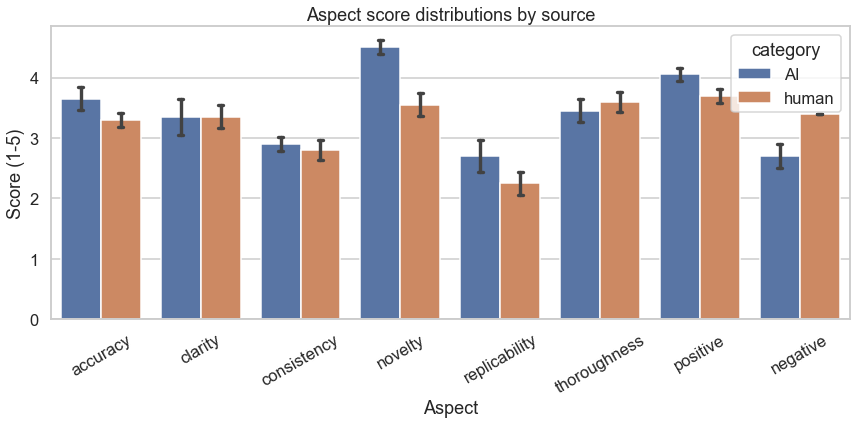

In [10]:
if aspect_stats_df.empty:
    print("No aspect statistics available for visualization.")
else:
    aspect_means_source = aspect_stats_df[aspect_stats_df["statistic"] == "mean_by_source"].dropna(subset=["value"])
    if aspect_means_source.empty:
        print("Aspect stats missing mean_by_source entries.")
    else:
        # Compute mean and std for each aspect/category combination
        summary = aspect_means_source.groupby(["aspect", "category"])["value"].agg(["mean", "std"]).reset_index()
        summary["std"] = summary["std"].fillna(0)

        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(data=aspect_means_source, x="aspect", y="value", hue="category", ax=ax, errorbar="sd", capsize=0.1)
        ax.set_title("Aspect score distributions by source")
        ax.set_ylabel("Score (1-5)")
        ax.set_xlabel("Aspect")
        plt.xticks(rotation=30)
        plt.tight_layout()
        fig_path = FIG_DIR / "aspect_scores_bar.png"
        fig.savefig(fig_path, dpi=150)
        print(f"Saved bar plot to {fig_path}")
        plt.show()

# In-domain AI reviewer versus outsider reviewer

Inferred paper domain for 4 submission(s) using reviewer mix counts.


/var/folders/r3/rj0t5xcj557855yt3xr0qwnh0000gn/T/ipykernel_50385/2399007950.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inferred_map = domain_means.groupby("submission_id").apply(_infer_submission_domain).to_dict()


Saved aspect focus comparison to /Users/tianyudu/Development/OB639-LLM-ABM-Simulation/figures/aggregation/aspect_focus_in_vs_out.png


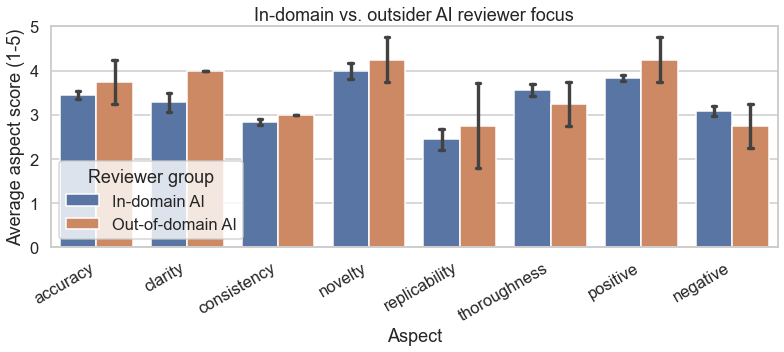

In [11]:
# Compare aspect focus for in-domain vs. outsider AI reviewers
if aspect_stats_df.empty:
    print("Aspect statistics are missing; run the extraction cells above first.")
else:
    domain_means = aspect_stats_df[aspect_stats_df["statistic"] == "mean_by_domain"].copy()
    if domain_means.empty:
        print("No domain-level aspect averages were found in the submitted payloads.")
    else:
        domain_counts = (
            aspect_stats_df[aspect_stats_df["statistic"] == "counts_by_domain"][
                ["submission_id", "category", "value"]
            ]
            .rename(columns={"value": "domain_review_count"})
        )
        domain_counts["domain_review_count"] = pd.to_numeric(domain_counts["domain_review_count"], errors="coerce")

        meta = submissions_df[["submission_id", "paper_domain"]].copy()
        domain_means = domain_means.merge(meta, on="submission_id", how="left")
        domain_means = domain_means.merge(domain_counts, on=["submission_id", "category"], how="left")

        def _normalize_domain(value: Any) -> Optional[str]:
            if pd.isna(value):
                return None
            text = str(value).strip().lower()
            if text in {"", "unknown", "n/a", "na", "none"}:
                return None
            return text

        domain_means["paper_domain_norm"] = domain_means["paper_domain"].apply(_normalize_domain)
        domain_means["category_norm"] = domain_means["category"].apply(_normalize_domain)
        domain_means = domain_means[domain_means["category_norm"].notna()].copy()

        def _infer_submission_domain(grp: pd.DataFrame) -> Optional[str]:
            counts = grp["domain_review_count"].fillna(0)
            if counts.empty or counts.max() <= 0:
                return None
            top_domains = grp.loc[counts == counts.max(), "category_norm"].dropna().unique()
            return top_domains[0] if len(top_domains) == 1 else None

        inferred_map = domain_means.groupby("submission_id").apply(_infer_submission_domain).to_dict()
        domain_means["inferred_paper_domain"] = domain_means["submission_id"].map(inferred_map)
        inferred_mask = domain_means["paper_domain_norm"].isna() & domain_means["inferred_paper_domain"].notna()
        if inferred_mask.any():
            inferred_count = domain_means.loc[inferred_mask, "submission_id"].nunique()
            print(f"Inferred paper domain for {inferred_count} submission(s) using reviewer mix counts.")
            domain_means.loc[inferred_mask, "paper_domain_norm"] = domain_means.loc[
                inferred_mask, "inferred_paper_domain"
            ]

        unresolved_rows = domain_means["paper_domain_norm"].isna().sum()
        if unresolved_rows:
            print(
                f"Dropping {unresolved_rows} rows with unknown paper domain (unable to infer in-domain reviewer group)."
            )
            domain_means = domain_means[domain_means["paper_domain_norm"].notna()].copy()

        if domain_means.empty:
            print("No domain-tagged rows remain after resolving metadata; cannot plot distributions.")
        else:
            domain_means["domain_group"] = np.where(
                domain_means["category_norm"] == domain_means["paper_domain_norm"],
                "in_domain",
                "out_domain",
            )

            group_counts = domain_means.groupby("domain_group")["submission_id"].nunique()
            missing_groups = [label for label in ("in_domain", "out_domain") if group_counts.get(label, 0) == 0]
            if missing_groups:
                print(
                    "Cannot compare in-domain vs. outsider reviewers because the submissions lack balanced metadata for: "
                    + ", ".join(missing_groups)
                )
            else:
                # Prepare plot data with group labels
                plot_df = domain_means.copy()
                plot_df["group"] = plot_df["domain_group"].map(
                    {"in_domain": "In-domain AI", "out_domain": "Out-of-domain AI"}
                )

                fig, ax = plt.subplots(figsize=(11, 5))
                sns.barplot(data=plot_df, x="aspect", y="value", hue="group", ax=ax, errorbar="sd", capsize=0.1)
                ax.set_ylabel("Average aspect score (1-5)")
                ax.set_xlabel("Aspect")
                ax.set_title("In-domain vs. outsider AI reviewer focus")
                ax.set_ylim(0, 5)
                ax.legend(title="Reviewer group")
                plt.xticks(rotation=30, ha="right")
                plt.tight_layout()
                focus_fig = FIG_DIR / "aspect_focus_in_vs_out.png"
                plt.savefig(focus_fig, dpi=150)
                print(f"Saved aspect focus comparison to {focus_fig}")
                plt.show()


# Decision of the paper based on the number of AI reviewers

Decision pies include 36 simulated editor runs sourced from 4 unique submission(s).
Saved decision pie charts to /Users/tianyudu/Development/OB639-LLM-ABM-Simulation/figures/aggregation/decision_pies_by_num_ai.png


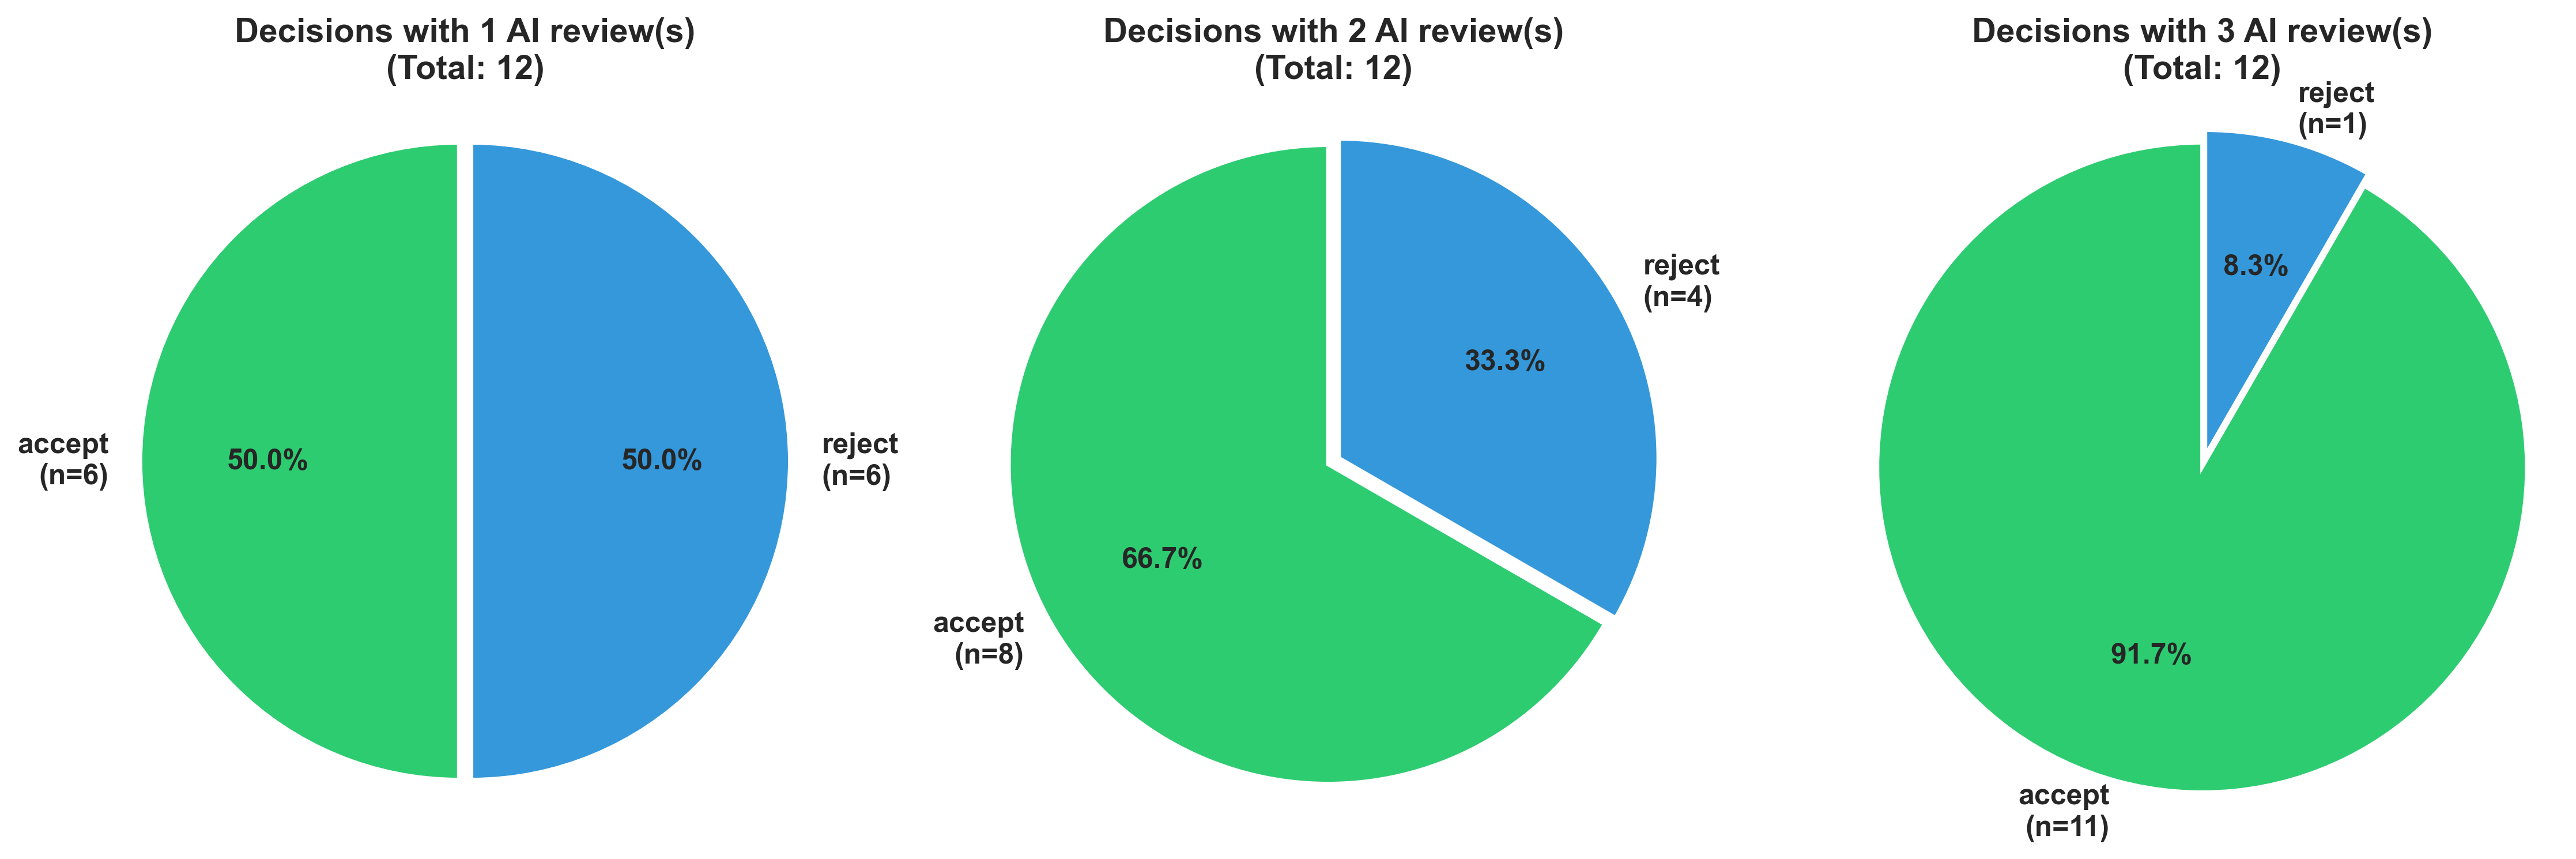

In [12]:
if human_ai_runs_df.empty:
    print("No human+AI mixture runs to visualize.")
else:
    contributing_submissions = human_ai_runs_df["submission_id"].nunique()
    total_runs = len(human_ai_runs_df)
    print(
        f"Decision pies include {total_runs} simulated editor runs sourced from {contributing_submissions} unique submission(s)."
    )

    decision_counts = (
        human_ai_runs_df.groupby(["num_ai_reviews", "parsed_decision"], dropna=False)
        .size()
        .reset_index(name="count")
    )
    total_counts = decision_counts.groupby("num_ai_reviews")["count"].transform("sum")
    decision_counts["share"] = np.where(total_counts > 0, decision_counts["count"] / total_counts, 0)

    unique_nums = sorted(decision_counts["num_ai_reviews"].dropna().unique())
    if not unique_nums:
        print("No valid num_ai_reviews values to plot pie charts.")
    else:
        n_plots = len(unique_nums)
        # Use a single row with N columns
        n_cols = n_plots
        n_rows = 1
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5), dpi=300)
        if n_plots == 1:
            axes = [axes]
        else:
            axes = np.array(axes).reshape(-1)

        colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']  # green, blue, orange, red

        for idx, num_ai in enumerate(unique_nums):
            ax = axes[idx]
            subset = decision_counts[decision_counts["num_ai_reviews"] == num_ai]
            labels = subset["parsed_decision"].fillna("Unknown decision")
            sizes = subset["share"].values
            counts = subset["count"].values
            if sizes.sum() == 0:
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.set_axis_off()
                continue

            # Create labels with absolute counts
            labels_with_counts = [f"{label}\n(n={int(count)})" for label, count in zip(labels, counts)]

            wedges, texts, autotexts = ax.pie(
                sizes,
                labels=labels_with_counts,
                autopct="%1.1f%%",
                startangle=90,
                colors=colors[:len(labels)],
                explode=[0.02] * len(labels),
                shadow=False,
                textprops={"fontsize": 12, "fontweight": "bold"},
            )
            ax.set_title(f"Decisions with {int(num_ai)} AI review(s)\n(Total: {int(sum(counts))})", fontsize=14, fontweight="bold")
            ax.axis("equal")

        plt.tight_layout()
        pie_path = FIG_DIR / "decision_pies_by_num_ai.png"
        plt.savefig(pie_path, dpi=150)
        print(f"Saved decision pie charts to {pie_path}")
        plt.show()

# Mixture of In-domain and Out-of-domain AI reviewers

Outsider-mix pies include 72 simulated editor runs sourced from 4 unique submission(s).
Saved outsider decision pie charts to /Users/tianyudu/Development/OB639-LLM-ABM-Simulation/figures/aggregation/decision_pies_by_num_outsiders.png


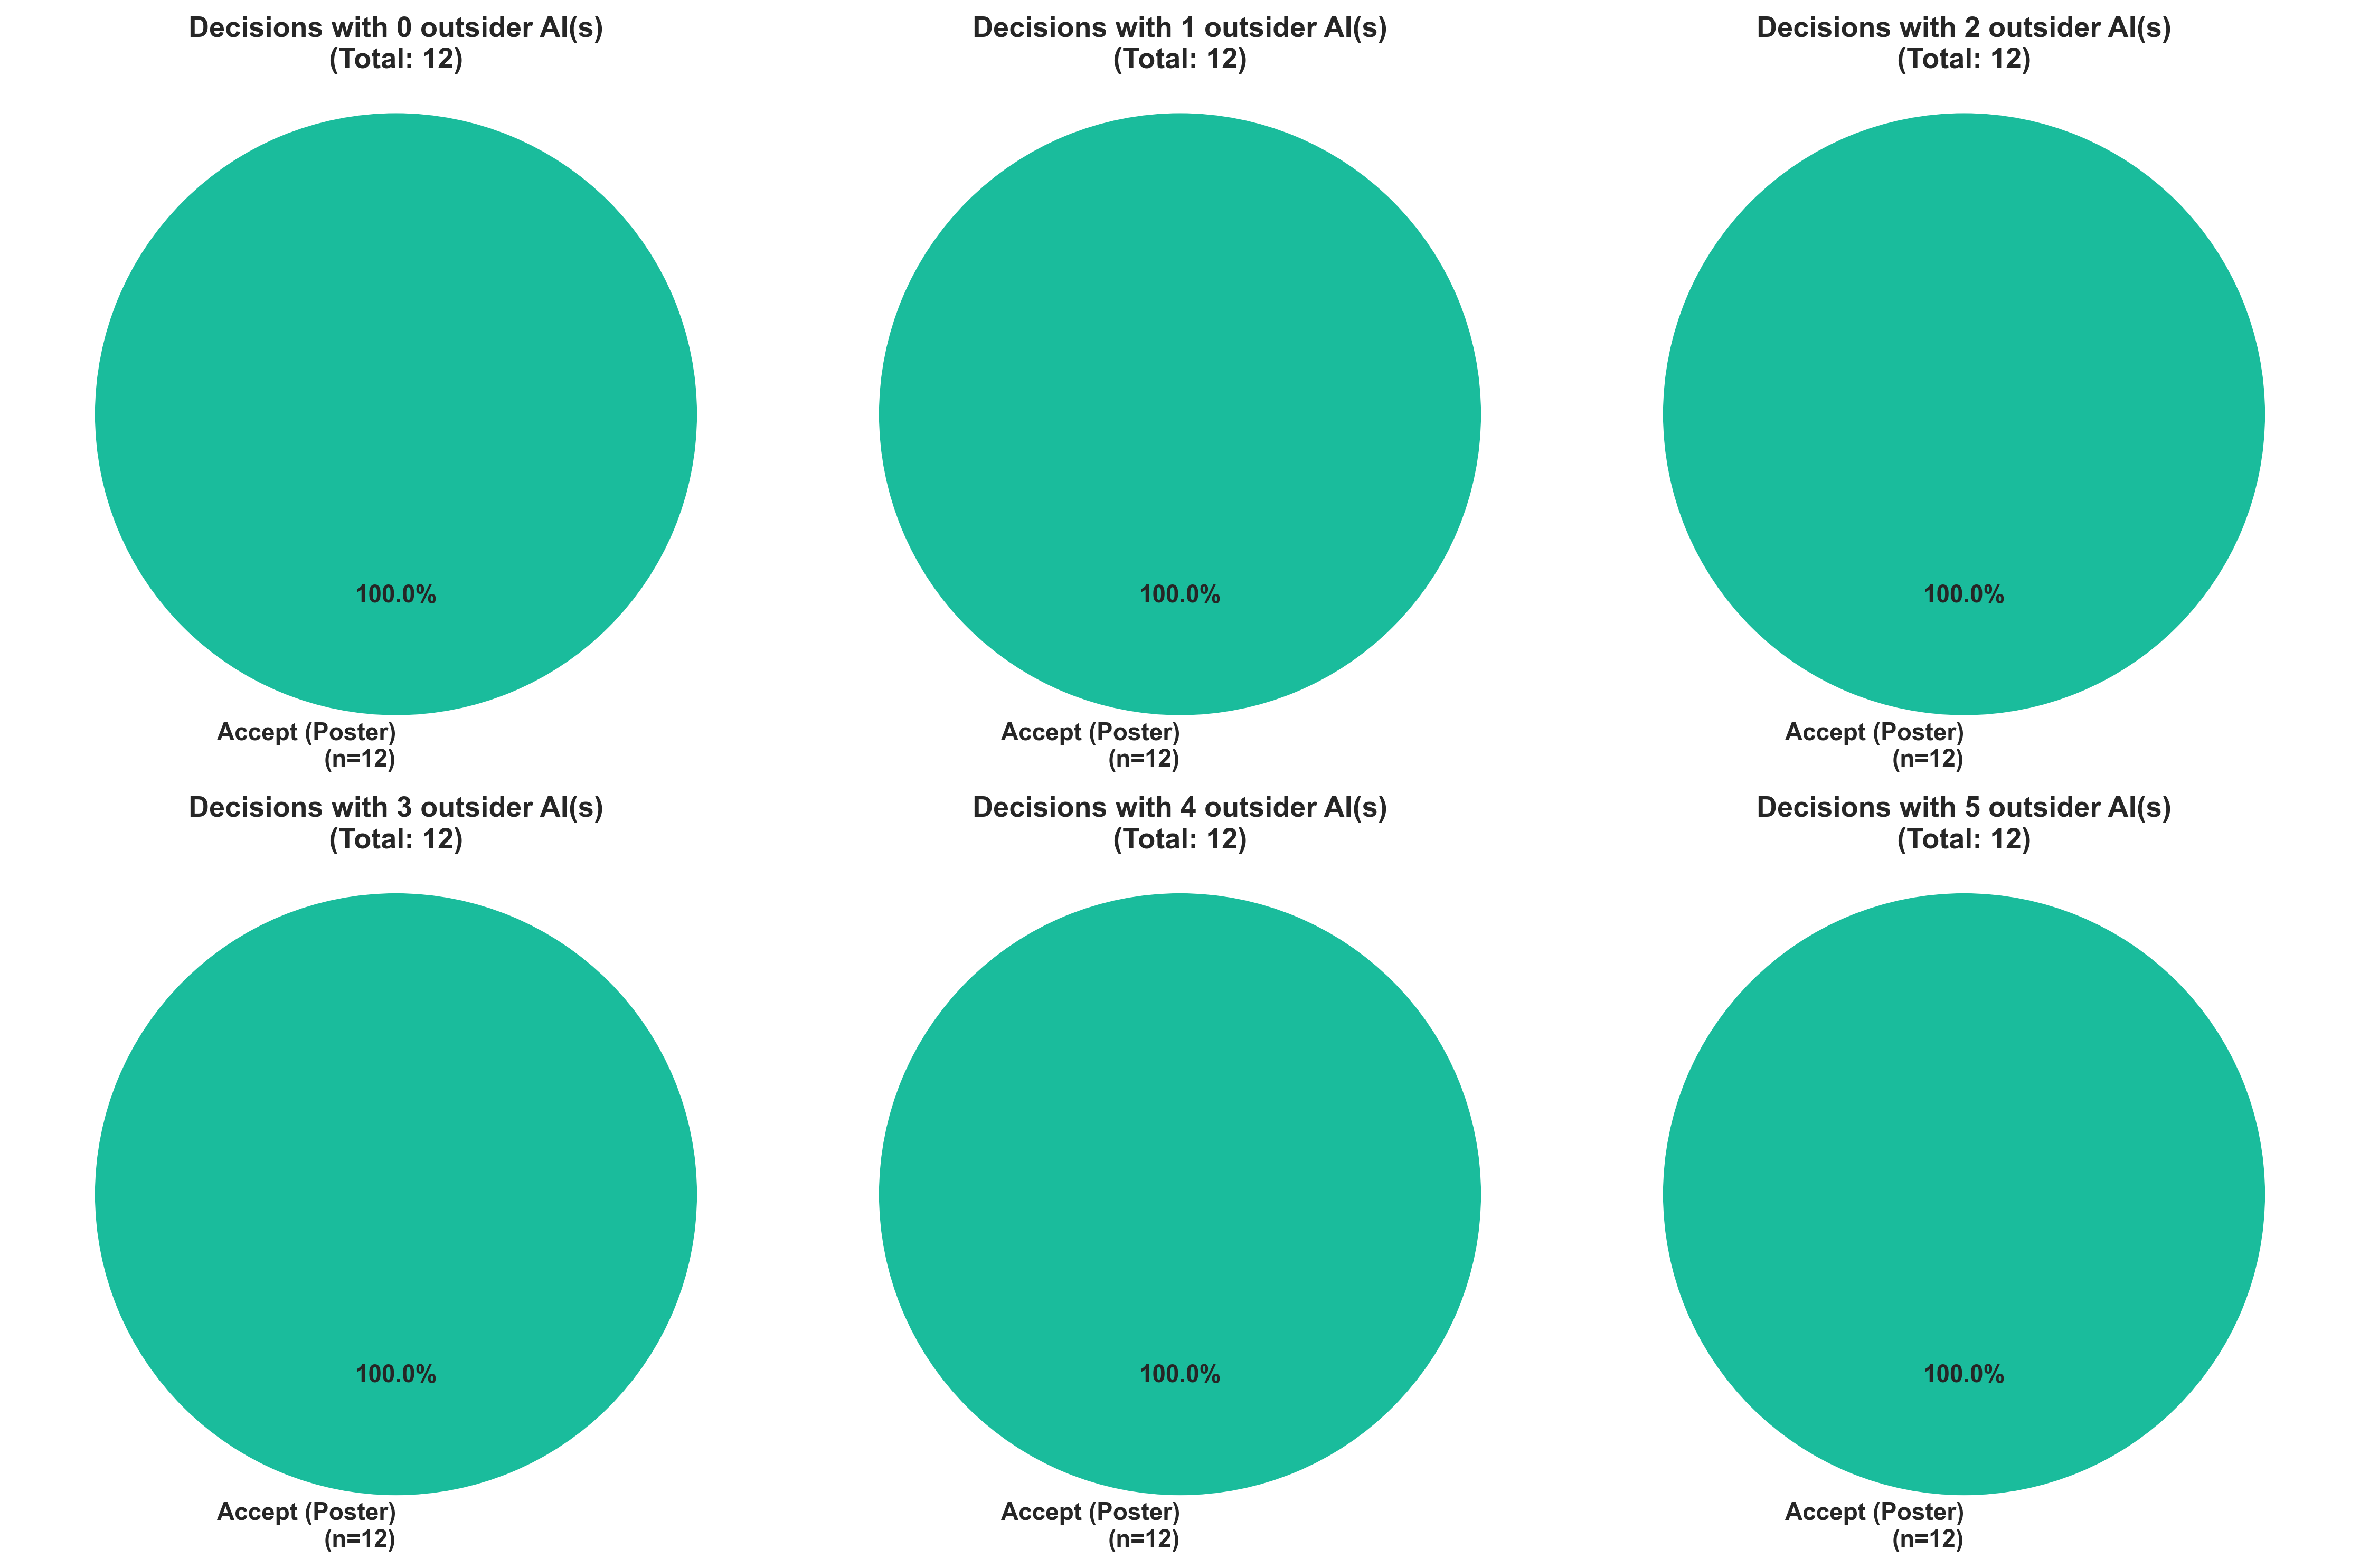

In [14]:
if outsider_runs_df.empty:
    print("No all-AI reviewer mixtures are available; collect submissions with outsider experiments first.")
else:
    contributing_submissions = outsider_runs_df["submission_id"].nunique()
    total_runs = len(outsider_runs_df)
    print(
        "Outsider-mix pies include {} simulated editor runs sourced from {} unique submission(s).".format(
            total_runs, contributing_submissions
        )
    )

    decision_counts = (
        outsider_runs_df.groupby(["num_outsiders", "parsed_decision_raw"], dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={"parsed_decision_raw": "editor_decision"})
    )
    total_counts = decision_counts.groupby("num_outsiders")["count"].transform("sum")
    decision_counts["share"] = np.where(total_counts > 0, decision_counts["count"] / total_counts, 0)

    unique_outsiders = sorted(decision_counts["num_outsiders"].dropna().unique())
    if not unique_outsiders:
        print("No valid num_outsiders values to plot pie charts.")
    else:
        n_plots = len(unique_outsiders)
        n_cols = int(np.ceil(np.sqrt(n_plots)))
        n_rows = int(np.ceil(n_plots / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), dpi=300)
        axes = np.array(axes).reshape(-1)

        colors = ['#1abc9c', '#3498db', '#9b59b6', '#e67e22', '#e74c3c']

        for idx, num_out in enumerate(unique_outsiders):
            ax = axes[idx]
            subset = decision_counts[decision_counts["num_outsiders"] == num_out]
            labels = subset["editor_decision"].fillna("Unknown decision")
            sizes = subset["share"].values
            counts = subset["count"].values
            if sizes.sum() == 0:
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.set_axis_off()
                continue

            labels_with_counts = [f"{label}\n(n={int(count)})" for label, count in zip(labels, counts)]
            wedges, texts, autotexts = ax.pie(
                sizes,
                labels=labels_with_counts,
                autopct="%1.1f%%",
                startangle=90,
                colors=colors[: len(labels)],
                explode=[0.02] * len(labels),
                shadow=False,
                textprops={"fontsize": 11, "fontweight": "bold"},
            )
            ax.set_title(
                "Decisions with {} outsider AI(s)\n(Total: {})".format(int(num_out), int(counts.sum())),
                fontsize=13,
                fontweight="bold",
            )
            ax.axis("equal")

        for j in range(len(unique_outsiders), len(axes)):
            axes[j].set_axis_off()

        plt.tight_layout()
        pie_path = FIG_DIR / "decision_pies_by_num_outsiders.png"
        plt.savefig(pie_path, dpi=150)
        print(f"Saved outsider decision pie charts to {pie_path}")
        plt.show()